In [1]:
import cProfile
import jax
import lsdb
import os
import numpy as np
import pandas as pd
import photod.locus as lt
import photod.bayes as bt

pd.set_option('display.max_columns', None)
jax.config.update('jax_platform_name', 'cpu')

Read photometric catalog with stars, for this we already prepared a small dataset based on SDSS S82.

Željko's pipeline example based on simulated TRILEGAL data had additionally the following cuts (only the first one can be implemented in S82): 
 - The input data are limited to 0.2 < g-i < 3.0 and 
 - -2.5 < FeH < 0 (probably OK in S82, maybe a few outliers) 
 - Mr > -1.0 (no very bright giants)
 - log(g) < 7 (no WDs, probably a small fraction exists in S82)
 - rmag < 26 (SDSS limiting mag is r~24, so this is not needed)

In [2]:
from dask.distributed import Client

client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33449 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33449/status,
Dashboard: http://127.0.0.1:33449/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45759,Workers: 96
Dashboard: http://127.0.0.1:33449/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:45913,Total threads: 1
Dashboard: http://127.0.0.1:38399/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:43295,


In [3]:
%%time 
s82 = lsdb.read_hats("/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed/")
#s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

CPU times: user 40.9 ms, sys: 14 ms, total: 54.9 ms
Wall time: 53.3 ms


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - S82_fixed'}>)

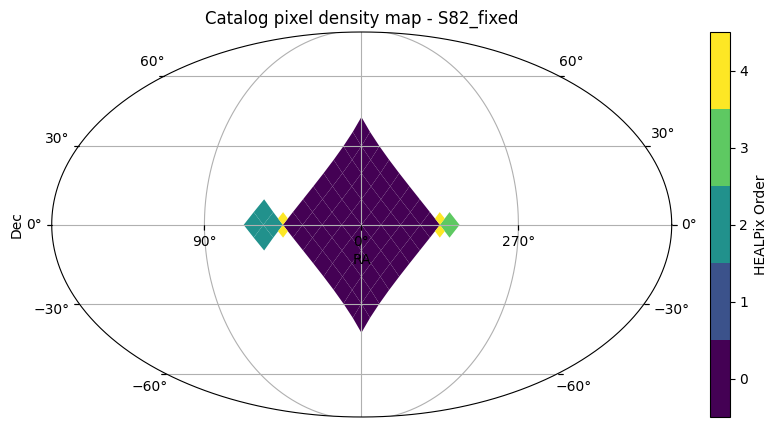

In [4]:
s82.plot_pixels()

Next, read the stellar locus parametrization.

In [5]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False) # fixForStripe82 was originally set to False
## select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)

# LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False, datafile="/home/scampos/photoD/data/MSandRGBcolors_v1.3.txt") # fixForStripe82 was originally set to False

Subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)

In [6]:
LSSTlocus

Mr,FeH,ug,gr,ri,iz,zy,gi
float64,float64,float64,float64,float64,float64,float64,float64
-1.0,-2.5,1.3805,0.578,0.265,0.1681,0.0803,0.843
-0.99,-2.5,1.3793,0.5776,0.2648,0.1679,0.0802,0.8424
-0.98,-2.5,1.3782,0.5772,0.2645,0.1676,0.0801,0.8417000000000001
-0.97,-2.5,1.377,0.5768,0.2643,0.1674,0.08,0.8411
-0.96,-2.5,1.3758,0.5764,0.264,0.1672,0.0799,0.8404
-0.95,-2.5,1.3747,0.5759,0.2638,0.167,0.0798,0.8396999999999999
-0.94,-2.5,1.3735,0.5755,0.2635,0.1668,0.0797,0.839
-0.93,-2.5,1.3724,0.5751,0.2632,0.1665,0.0796,0.8382999999999999
-0.92,-2.5,1.3712,0.5747,0.263,0.1663,0.0795,0.8377


In [7]:
kMr = 10 # 10x less samples
kFeH = 2 # 2x less samples
locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


Prepare the priors, see TRILEGAL-makePriors-forS82.ipynb notebook (work in progress).

Process data...

In [8]:
fitColors = ('ug', 'gr', 'ri', 'iz')
pix_order = 5
pix_index = 7507 # 4506 # 0
# /mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0
# priorsRootName = f'/mnt/beegfs/scratch/scampos/photod/priors/TRILEGAL/S82/{pix_order}/{pix_index}'
priorsRootName = f'/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/{pix_order}/{pix_index}'

Make 3D locus list with three ArGrid limits and resolutions.

In [9]:
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)

Select a range of stars to process.

In [10]:
df = s82.pixel_search([(pix_order,pix_index)]).compute().reset_index(drop=True)
df

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,uErr,umrms,umchi2,gNobs,gmag,gmmu,gErr,gmrms,gmchi2,rNobs,rmag,rmmu,rErr,rmrms,rmchi2,iNobs,imag,immu,iErr,imrms,imchi2,zNobs,zmag,zmmu,zErr,zmrms,zmchi2,Norder,Dir,Npix,Mr,FeH,MrEst,MrEstUnc,FeHEst,ug,gr,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
0,CALIBSTARS_0000001,308.500219,-1.227713,0.0227,0.0227,7,0.587,3,23.87,23.823,0.611,0.06,0.056,6,22.388,22.269,0.05,0.154,1.554,7,20.832,20.834,0.017,0.056,1.05,7,20.168,20.202,0.015,0.046,1.105,7,19.9,19.818,0.04,0.116,1.212,3,0,469,-99,-99,-99,-99,-99,1.482,1.556,2.22,0.664,0.268,0.613042,0.052811,0.052202,0.022672,0.04272,44.115806,-23.253706
1,CALIBSTARS_0000002,308.500072,-1.240266,0.0141,0.0141,7,0.596,4,21.97,21.966,0.093,0.045,0.225,7,20.488,20.462,0.014,0.042,1.116,7,19.763,19.768,0.011,0.052,0.299,7,19.532,19.504,0.013,0.032,0.808,7,19.439,19.386,0.034,0.095,0.824,3,0,469,-99,-99,-99,-99,-99,1.482,0.725,0.956,0.231,0.093,0.094048,0.017804,0.019105,0.017029,0.036401,44.103796,-23.259693
2,CALIBSTARS_0000003,308.500101,-1.217158,0.0154,0.0154,7,0.579,7,19.394,19.385,0.012,0.021,0.625,6,17.977,17.977,0.005,0.008,0.566,7,17.318,17.317,0.004,0.008,0.889,7,17.052,17.05,0.005,0.027,1.752,6,16.873,16.874,0.007,0.004,0.215,3,0,469,-99,-99,-99,-99,-99,1.417,0.659,0.925,0.266,0.179,0.013,0.006403,0.007071,0.006403,0.008602,44.125775,-23.24846
3,CALIBSTARS_0000004,308.501912,-1.176494,0.0117,0.0117,7,0.559,7,20.605,20.598,0.028,0.081,0.852,6,18.457,18.459,0.006,0.007,0.428,7,17.549,17.556,0.005,0.022,0.797,6,17.198,17.188,0.006,0.007,0.496,7,16.968,16.966,0.009,0.022,0.653,3,0,469,-99,-99,-99,-99,-99,2.148,0.908,1.259,0.351,0.23,0.028636,0.00781,0.008485,0.00781,0.010817,44.165378,-23.230222
4,CALIBSTARS_0000005,308.504615,-1.174191,0.04,0.04,7,0.556,2,23.955,23.985,0.634,0.103,0.114,5,23.084,23.022,0.097,0.133,0.542,7,21.299,21.326,0.025,0.06,0.992,7,20.347,20.331,0.016,0.061,1.381,7,19.861,19.747,0.036,0.168,1.733,3,0,469,-99,-99,-99,-99,-99,0.871,1.785,2.737,0.952,0.486,0.641377,0.10017,0.098311,0.029682,0.039395,44.169,-23.231459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149217,CALIBSTARS_0172463,314.468155,-0.122635,0.0732,0.0732,16,0.224,4,24.298,24.308,0.467,0.071,0.07,9,22.87,22.826,0.051,0.068,0.406,14,21.534,21.496,0.021,0.103,0.917,14,20.28,20.265,0.011,0.084,1.951,15,19.616,19.627,0.023,0.131,1.194,3,0,469,-99,-99,-99,-99,-99,1.428,1.336,2.59,1.254,0.664,0.469777,0.055154,0.052173,0.023707,0.025495,48.488148,-27.86766
149218,CALIBSTARS_0172472,314.449541,0.349252,0.0595,0.0595,15,0.226,6,24.484,24.405,0.444,0.134,0.114,8,22.994,22.974,0.071,0.074,0.415,14,21.59,21.56,0.026,0.074,0.653,15,20.565,20.534,0.014,0.049,0.98,13,20.031,20.002,0.037,0.113,0.846,3,0,469,-99,-99,-99,-99,-99,1.49,1.404,2.429,1.025,0.534,0.449641,0.075611,0.072367,0.02953,0.03956,48.933913,-27.608118
149219,CALIBSTARS_0172473,314.617689,0.289014,0.0657,0.0657,16,0.224,7,24.189,24.128,0.39,0.103,0.097,9,22.759,22.83,0.055,0.181,0.8,16,21.477,21.434,0.02,0.083,0.886,16,20.585,20.586,0.014,0.084,1.28,11,20.161,20.169,0.043,0.13,0.832,3,0,469,-99,-99,-99,-99,-99,1.43,1.282,2.174,0.892,0.424,0.393859,0.058523,0.056754,0.024413,0.045222,48.97407,-27.783153
149220,CALIBSTARS_0172481,314.503422,-0.172563,0.0761,0.0761,16,0.244,6,24.196,24.16,0.339,0.324,0.363,14,22.92,22.912,0.049,0.128,0.572,16,21.515,21.503,0.02,0.043,0.444,16,20.605,20.608,0.013,0.091,1.568,14,20.156,20.133,0.034,0.073,0.631,3,0,469,-99,-99,-99,-99,-99,1.276,1.405,2.315,0.91,0.449,0.342523,0.052924,0.050695,0.023854,0.036401,48.460242,-27.923591


In [13]:
df[df["CALIBSTARS"] == "CALIBSTARS_0003251"]

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,uErr,umrms,umchi2,gNobs,gmag,gmmu,gErr,gmrms,gmchi2,rNobs,rmag,rmmu,rErr,rmrms,rmchi2,iNobs,imag,immu,iErr,imrms,imchi2,zNobs,zmag,zmmu,zErr,zmrms,zmchi2,Norder,Dir,Npix,Mr,FeH,MrEst,MrEstUnc,FeHEst,ug,gr,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
3165,CALIBSTARS_0003251,308.969564,-0.768379,0.0142,0.0142,7,0.334,7,20.568,20.554,0.025,0.076,1.105,7,19.394,19.386,0.006,0.019,1.246,7,18.94,18.945,0.005,0.016,0.964,5,18.744,18.745,0.007,0.003,0.233,7,18.685,18.682,0.015,0.037,0.969,3,0,469,-99,-99,-99,-99,-99,1.174,0.454,0.65,0.196,0.059,0.02571,0.00781,0.00922,0.008602,0.016553,44.80219,-23.438281


In [20]:
iStart = 0
iEnd = 4000 # len(df)
# myStars = [0,1] # [0, 100, 1000, 10000] # for illustration, make plots for these stars
myStars = [3164, 3165, 3166] # [0, 100, 1000, 10000] # for illustration, make plots for these stars

In [15]:
from photod.parameters import GlobalParams

global_params = GlobalParams(
    fitColors=fitColors,
    locusData=locusData,
    ArGridList=ArGridList,
    locus3DList=locus3DList,
    priorsRootName=priorsRootName,
)

with cProfile.Profile() as profiler:
    results, estimates_df = bt.make_bayes_estimates_3d(df, global_params, iStart, iEnd)
    profiler.dump_stats("bayes-3d.pstat")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [16]:
estimates_df

,glon,glat,FeHEst,FeHUnc,MrEst,MrUnc,chi2min,MrdS,FeHdS,ArEst,ArUnc,ArdS
0,44.115806,-23.253706,-0.578350,0.421545,7.887649,0.448283,11.226912,-21.414679,-6.999166,0.606305,0.246458,-67.063637
1,44.103796,-23.259693,-1.820359,0.421400,6.856178,0.346583,3.012950,-27.158131,-3.007559,0.126134,0.099889,-142.695816
2,44.125775,-23.24846,-1.428749,0.365703,3.865121,2.181536,24.304070,-11.615690,0.286119,0.480282,0.165058,-119.047371
3,44.165378,-23.230222,-0.328237,0.162518,5.979404,0.225368,21.403971,-27.641493,-9.607907,0.508177,0.062299,-176.406830
4,44.169,-23.231459,-0.540799,0.394567,8.928671,0.417514,11.176970,-23.138245,-7.918833,0.813615,0.271840,-59.923416
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,46.479496,-22.591286,-1.843509,0.274599,6.366534,0.296045,5.323856,-26.322567,-6.378912,0.154091,0.087865,-142.952179
3996,46.347304,-22.560673,-0.327756,0.246071,9.118792,0.226610,6.239366,-31.965408,-13.224769,0.370542,0.049592,-181.355927
3997,46.327514,-22.572455,-0.573241,0.428724,7.100591,0.343032,10.514879,-25.751665,-5.867105,0.100989,0.084822,-156.348602
3998,46.331206,-22.571236,-0.325906,0.231856,8.743709,0.220245,2.262437,-30.950253,-12.436676,0.380233,0.053004,-176.319229


In [17]:
# Create directories for the plots and results
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [18]:
# Save estimates to disk
outfile = 'results/S82_Bayes_estimates2.txt'
estimates_df.to_csv(outfile, index=False)

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 3164
pts: 25 155


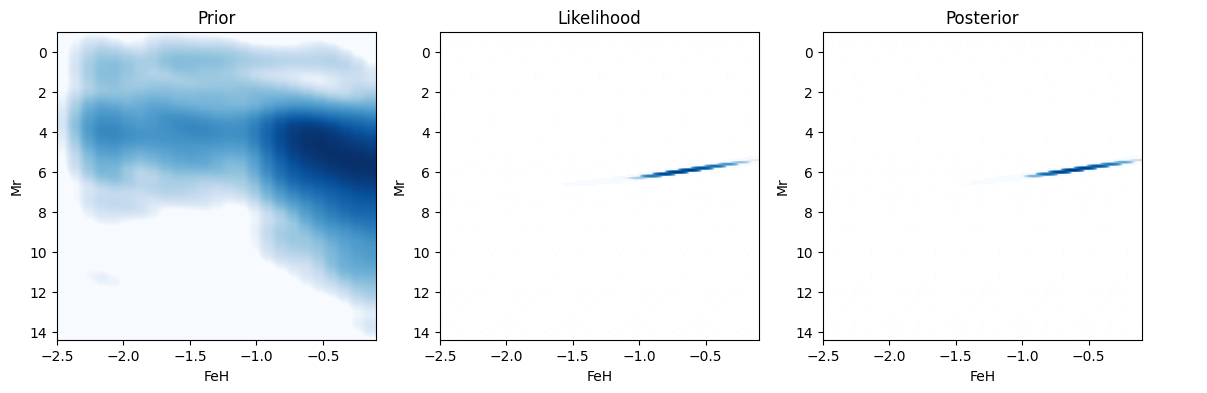

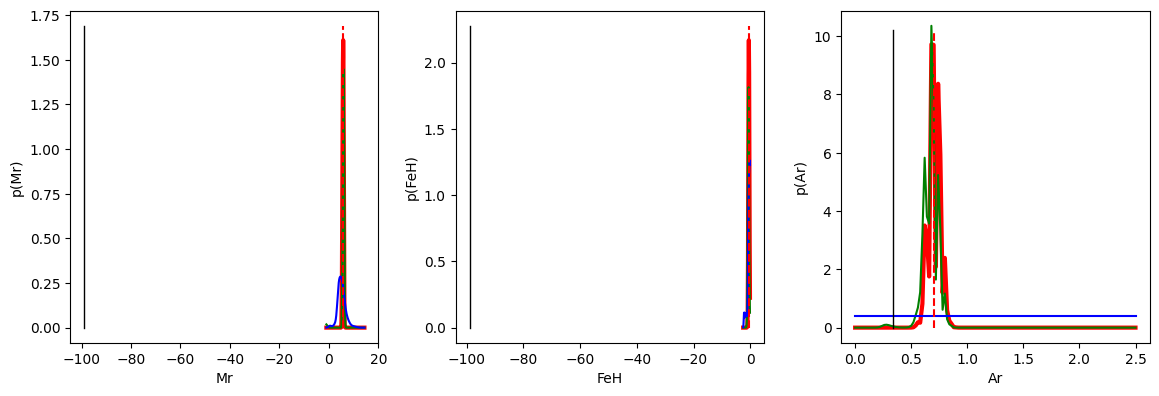

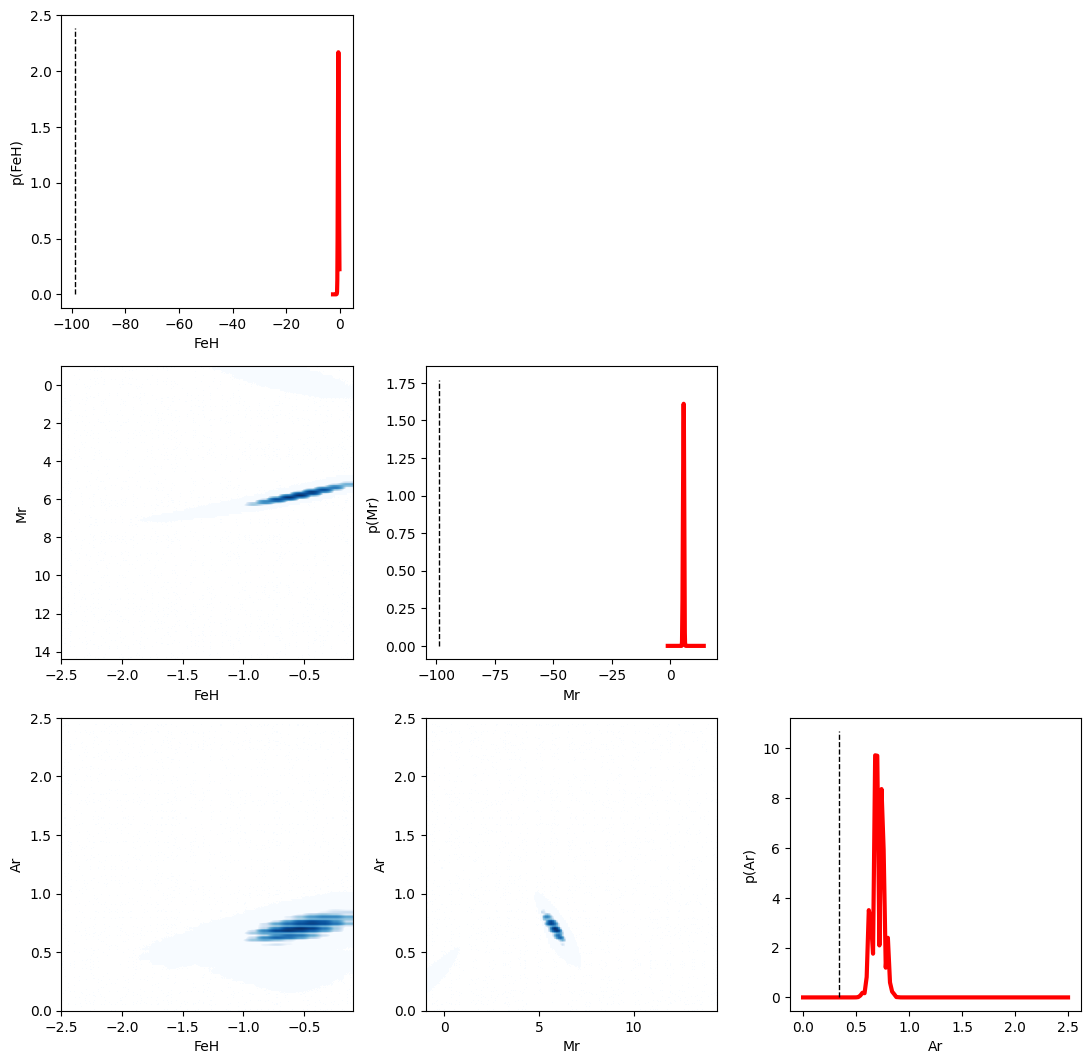

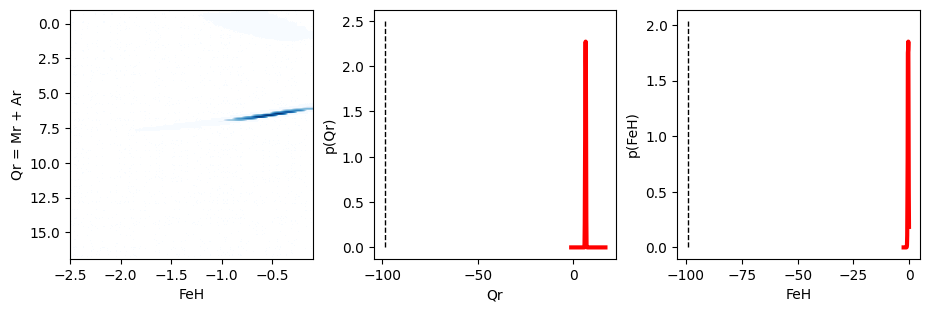

6.5192986 0.19513842
Plotting star 3165
pts: 25 155


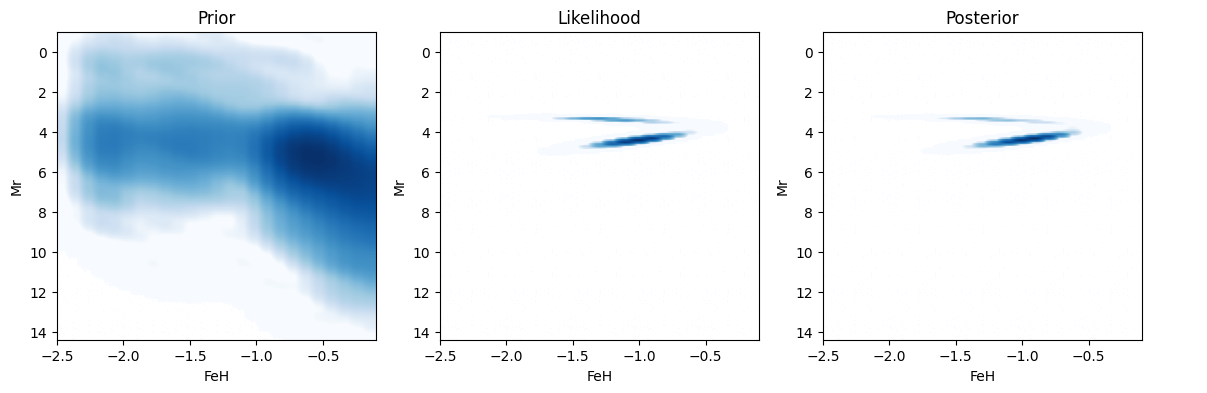

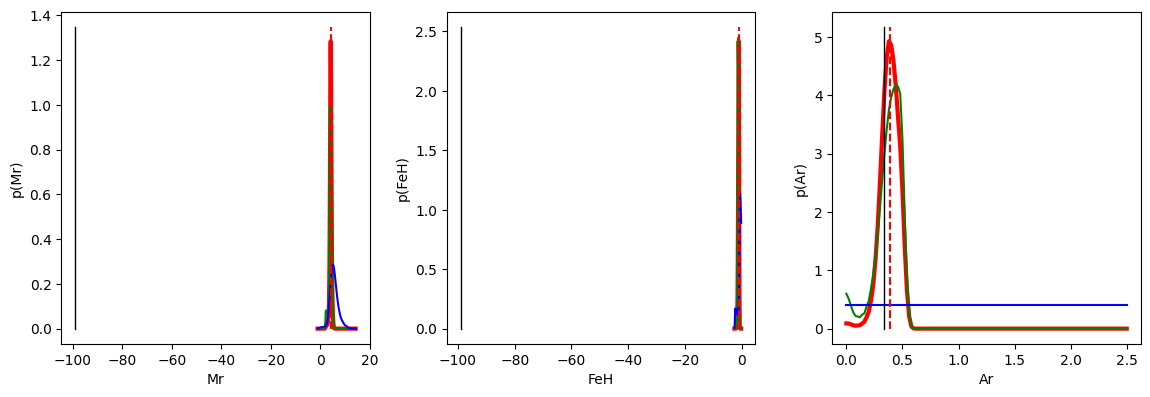

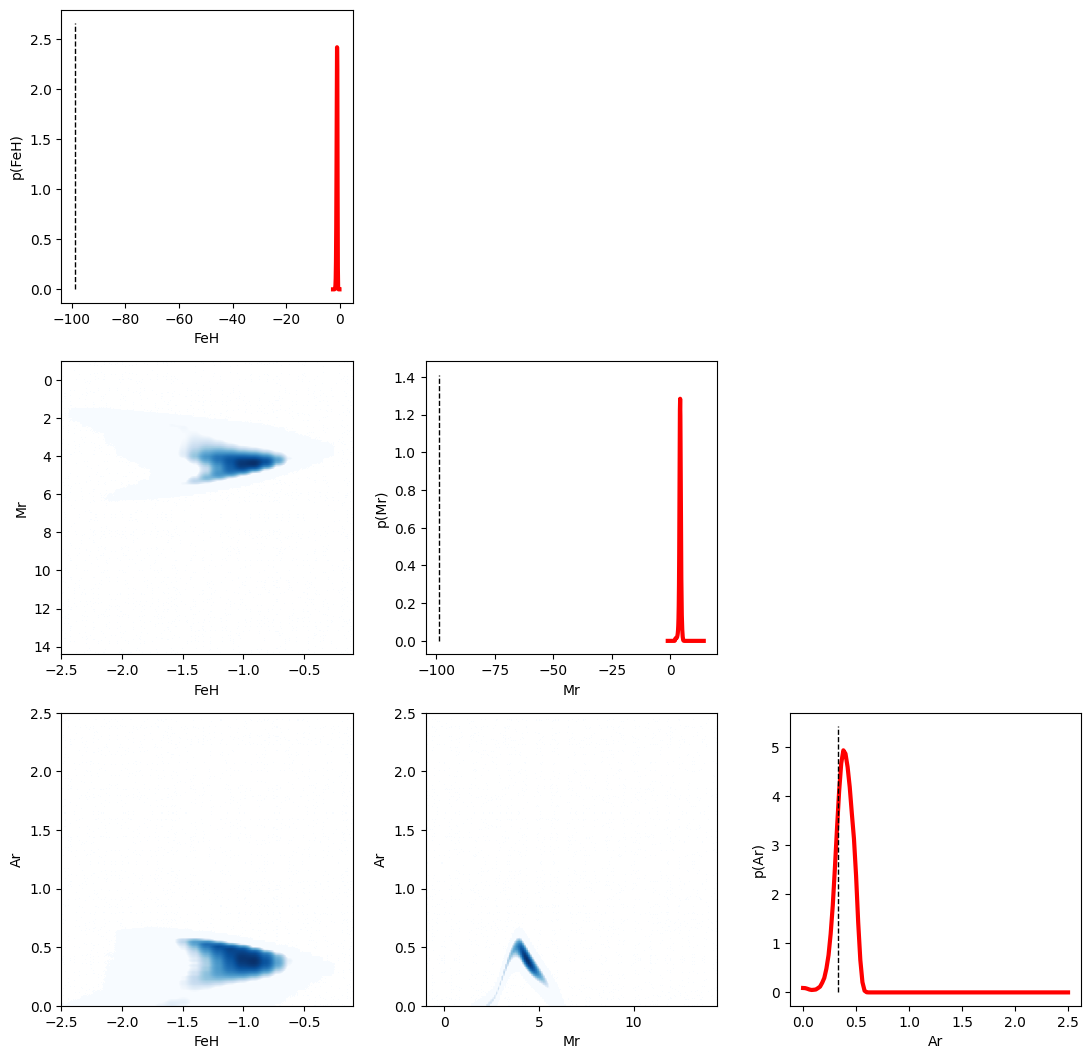

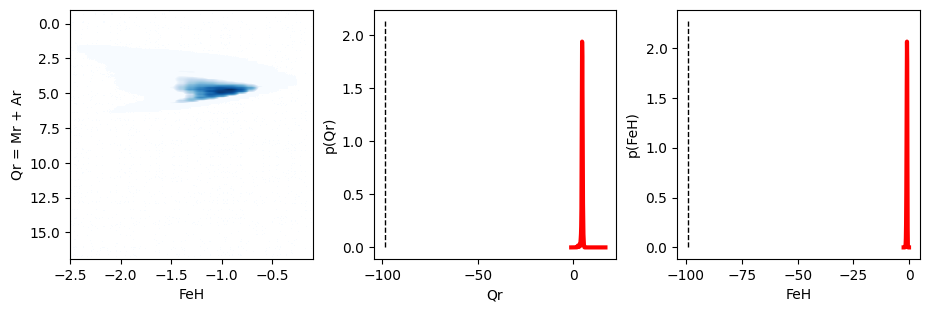

4.7136645 0.38040605
Plotting star 3166
pts: 25 155


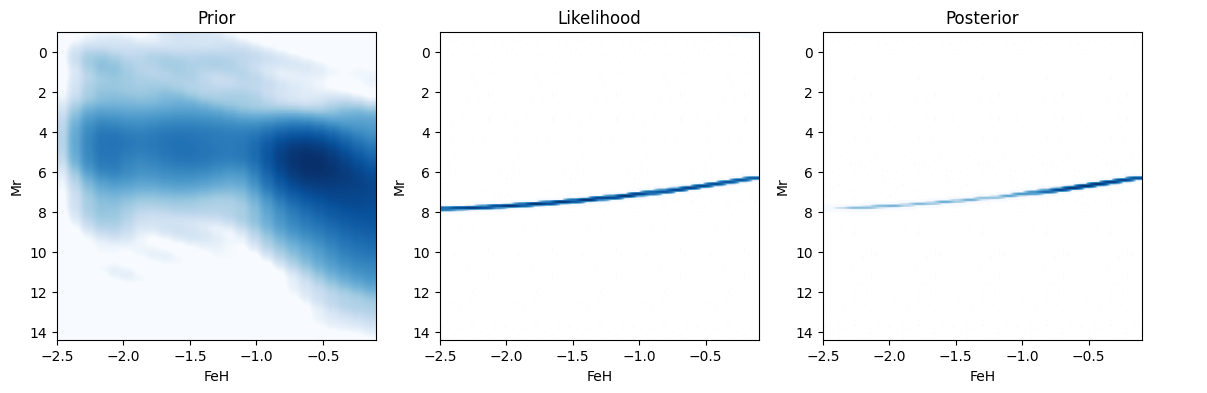

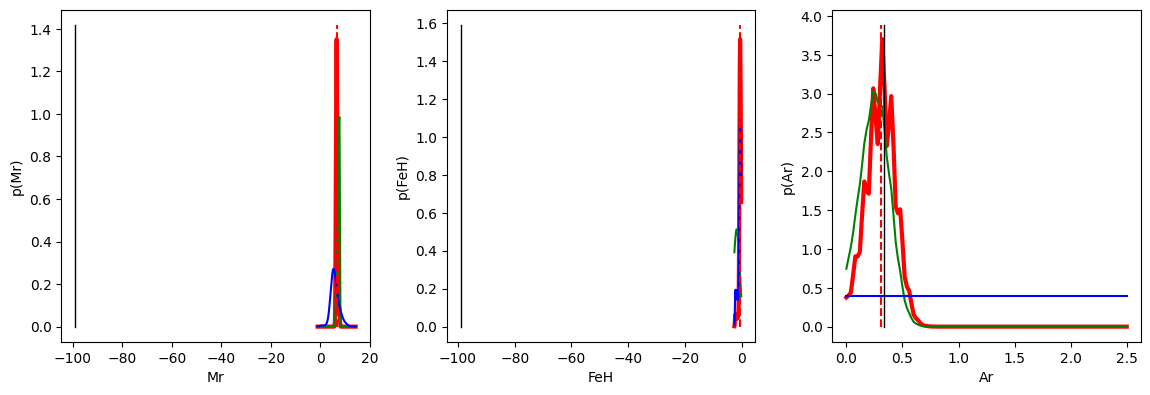

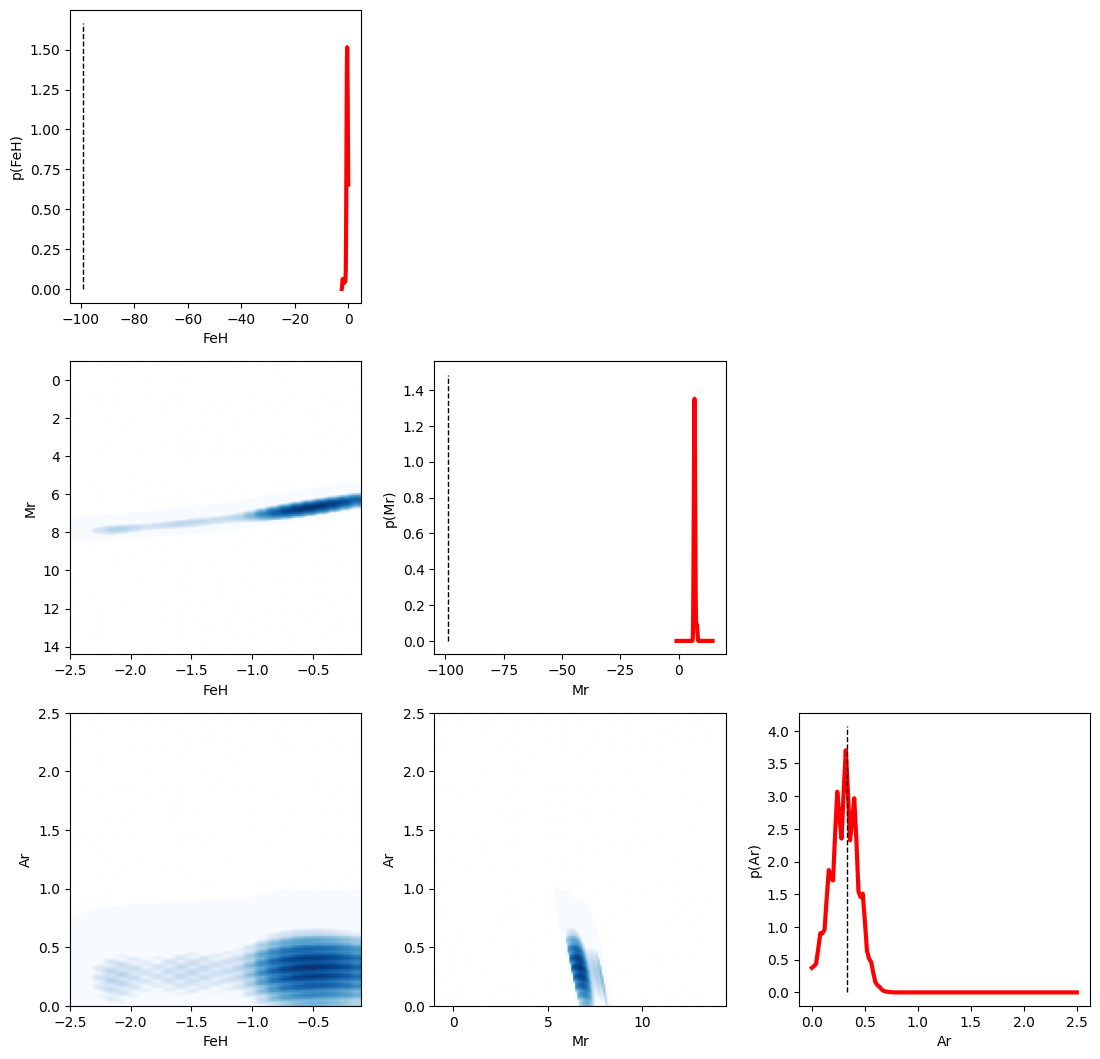

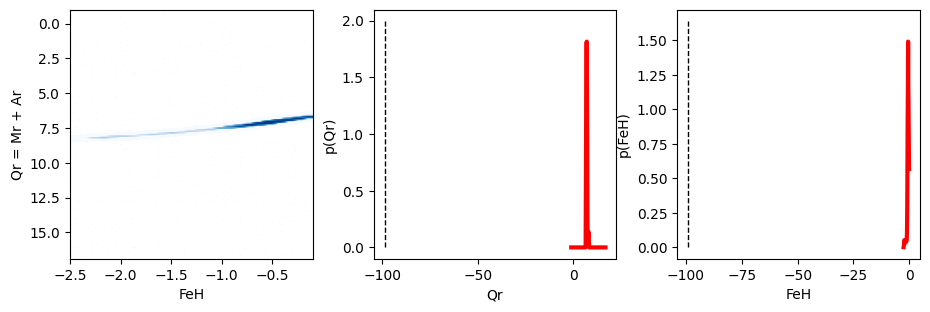

7.106157 0.30223724


In [21]:
# Plot the results for two of the stars
bt.plot_stars(df, *results.get_plotting_args(), *global_params.get_plotting_args(), plotStars=myStars)

Managed to run the code with a very limited sample, 4000 stars only.

When running using all the stars within a healpix, the kernel restarts.